# Named Entity Recognition (NER) using BiLSTM

### Import Required Libraries

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Optional
from collections import Counter
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer


### Dataset Loading Functions

In [ ]:
def load_dataset(data_dir: str):
    """
    Loads text and annotation files to generate NER-ready data.

    Args:
        data_dir: Directory containing `.txt` and `.ann` files.

    Returns:
        A list of tuples (tokens, labels).
    """
    data = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".txt"):
            text_path = os.path.join(data_dir, filename)
            annotation_path = os.path.splitext(text_path)[0] + ".ann"

            # Load text
            with open(text_path, 'r', encoding='utf-8') as text_file:
                text = text_file.read()
                tokens = text.split()

            # Load annotations
            entities = []
            if os.path.exists(annotation_path):
                with open(annotation_path, 'r', encoding='utf-8') as ann_file:
                    for line in ann_file:
                        if line.startswith("T"):
                            parts = line.strip().split('\t')
                            if len(parts) >= 3:
                                entity_info = parts[1].split()
                                label = entity_info[0]
                                try:
                                    start = int(entity_info[1].split(';')[0])
                                    end = int(entity_info[2].split(';')[0])
                                    entities.append({"label": label, "start": start, "end": end})
                                except ValueError:
                                    print(f"Skipping malformed entity in {annotation_path}: {line}")
                                    continue

            # Align tokens and labels
            labels = align_tokens_with_entities(tokens, entities)
            data.append((tokens, labels))

    return data


In [ ]:
def align_tokens_with_entities(tokens: List[str], entities: List[Dict[str, int]]) -> List[str]:
    """
    Align entities with tokens to generate BIO labels.

    Args:
        tokens: List of tokens.
        entities: List of entities with their positions.

    Returns:
        A list of BIO labels aligned with tokens.
    """
    labels = ["O"] * len(tokens)
    token_starts = []
    current_position = 0

    for token in tokens:
        token_starts.append(current_position)
        current_position += len(token) + 1

    for entity in entities:
        for i, start_pos in enumerate(token_starts):
            token_end_pos = start_pos + len(tokens[i])
            if entity["start"] <= start_pos and token_end_pos <= entity["end"]:
                labels[i] = f"B-{entity['label']}" if start_pos == entity["start"] else f"I-{entity['label']}"

    return labels

### Load Dataset

In [ ]:
data_dir = "/kaggle/input/maccrobat2020/MACCROBAT2020"
dataset = load_dataset(data_dir)

### Vocabulary Implementation

In [ ]:
class Vocabulary():
    """
    Handles mapping between tokens/labels and numerical indices
    """
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int=1):
        self.stoi = dict() # String to index
        self.itos = dict() # Index to string
        if counter is not None:
            idx = 0
            # Add special tokens first
            for s in specials:
                self.stoi[s] = idx
                self.itos[idx] = s
                idx += 1

            # Add frequent tokens
            for tok, freq in counter.items():
                if freq >= min_freq:
                    self.stoi[tok] = idx
                    self.itos[idx] = tok
                    idx += 1

    def save(self, path, fname):
        """Save vocabulary to file"""
        state = {"stoi": self.stoi, "itos": self.itos}
        with open(os.path.join(path, fname), 'w') as f:
            json.dump(state, f)

    def load(self, fpath):
        """Load vocabulary from file"""
        with open(fpath, 'r') as f:
            state = json.load(f)
        self.stoi = {s: int(i) for s, i in state["stoi"].items()}
        self.itos = {int(i): s for i, s in state["itos"].items()}

    def __len__(self):
        return len(self.itos)

In [ ]:
def build_vocab(data, min_freq=1):
    """Build vocabulary from token/label data"""
    counter = Counter(data)
    return Vocabulary(counter, specials=['<pad>', '<unk>'], min_freq=min_freq)

### Dataset and DataLoader Implementation

In [ ]:
class NERDataset(Dataset):
    """
    PyTorch Dataset class for NER data
    """
    def __init__(self, data, vocab, label_vocab, window_size):
        self.data = data
        self.vocab = vocab # Token vocabulary
        self.label_vocab = label_vocab # Label vocabulary
        self.window_size = window_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Return numericalized tokens and labels"""
        tokens, labels = self.data[idx]
        # Convert tokens to indices
        token_ids = [self.vocab.stoi.get(token, self.vocab.stoi['<unk>']) for token in tokens]
        # Convert labels to indices
        label_ids = [self.label_vocab.stoi[label] for label in labels]
        return torch.tensor(token_ids), torch.tensor(label_ids)


In [ ]:
def pad_sequences(sequences, pad_value, max_length=None):
    """
    Pads a list of sequences to the same length.

    Args:
        sequences: List of lists (e.g., tokens or labels).
        pad_value: Value to use for padding.
        max_length: Maximum length to pad to. If None, uses the length of the longest sequence.

    Returns:
        A list of padded sequences and the original lengths.
    """
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)

    padded_sequences = []
    original_lengths = []

    for seq in sequences:
        original_lengths.append(len(seq))
        padded_seq = seq + [pad_value] * (max_length - len(seq))
        padded_sequences.append(padded_seq)

    return padded_sequences, original_lengths

In [ ]:
def collate_fn_manual(batch):
    """
    Custom collate function to pad tokens and labels manually in a batch.

    Args:
        batch: List of tuples (tokens, labels) from the dataset.

    Returns:
        Padded tensors for tokens and labels.
    """
    tokens, labels = zip(*batch)
    
    # Convert to list of lists
    tokens = [list(seq.numpy()) for seq in tokens]
    labels = [list(seq.numpy()) for seq in labels]

    # Pad tokens and labels
    tokens_padded, _ = pad_sequences(tokens, pad_value=vocab.stoi['<pad>'])
    labels_padded, _ = pad_sequences(labels, pad_value=label_vocab.stoi['<pad>'])

    return torch.tensor(tokens_padded), torch.tensor(labels_padded)

### Model Architecture

In [ ]:
class BiLSTMNER(nn.Module):
    """
    Bidirectional LSTM model for NER
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, bidirectional=True, dropout=0.5):
        super(BiLSTMNER, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # BiLSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # Calculate LSTM output dimension
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        # Final classification layer
        self.fc = nn.Linear(lstm_output_dim, num_classes)

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)
        # LSTM layer
        x, _ = self.lstm(x)
        # Dropout
        x = self.dropout(x)
        # Final classification
        x = self.fc(x)
        return x


### Training Setup

In [ ]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    """
    Train the BiLSTM model
    """
    model.to(device)
    all_epoch_losses = []
    all_predictions = []
    all_labels = []

    for epoch in range(epochs):
        # Training mode
        model.train()
        train_loss = 0.0

        # Training phase
        for tokens, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            tokens, labels = tokens.to(device), labels.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(tokens)
            
            # Reshape for loss calculation
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Collect predictions for evaluation
            predictions = outputs.argmax(dim=-1).cpu().numpy()
            labels_np = labels.cpu().numpy()

            # Filter out padding tokens
            mask = labels_np != label_vocab.stoi['<pad>']
            all_predictions.extend(predictions[mask])
            all_labels.extend(labels_np[mask])

        # Calculate average loss
        mean_loss = train_loss / len(train_loader)
        all_epoch_losses.append(mean_loss)
        print(f"Epoch {epoch+1}, Loss: {mean_loss:.4f}")

    # Final evaluation
    print("\nÉvaluation finale après entraînement :")
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=list(label_vocab.itos.values()),
        zero_division=0
    )
    print(report)
    return all_epoch_losses, report

In [ ]:
# Flatten tokens and labels
all_tokens = [token for tokens, _ in dataset for token in tokens]
all_labels = [label for _, labels in dataset for label in labels]

# Build vocabularies
vocab = build_vocab(all_tokens)
label_vocab = build_vocab(all_labels)


In [ ]:
# Model hyperparameters
window_size = 50
embed_dim = 100
hidden_dim = 128
num_classes = len(label_vocab)
batch_size = 32
learning_rate = 0.001
epochs = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'


### Model Training Execution

In [ ]:
# Prepare Dataset and DataLoader
train_dataset = NERDataset(dataset, vocab, label_vocab, window_size)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_manual
)

In [ ]:
import matplotlib.pyplot as plt
# Visualization 
def plot_learning_curve(train_losses):
    """
    Plot training loss curve
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.grid()
    plt.legend()
    plt.show()




In [ ]:
# Initialize model components
model = BiLSTMNER(len(vocab), embed_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss(ignore_index=label_vocab.stoi['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Start training
losses, final_report = train_model(model, train_loader, None, criterion, optimizer, epochs, device)
print("\nFinal Losses:", losses)

Training Epoch 1/200: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch 1, Loss: 4.2705


Training Epoch 2/200: 100%|██████████| 7/7 [00:00<00:00, 20.72it/s]


Epoch 2, Loss: 3.6795


Training Epoch 3/200: 100%|██████████| 7/7 [00:00<00:00, 23.47it/s]


Epoch 3, Loss: 2.3892


Training Epoch 4/200: 100%|██████████| 7/7 [00:00<00:00, 23.54it/s]


Epoch 4, Loss: 2.1991


Training Epoch 5/200: 100%|██████████| 7/7 [00:00<00:00, 24.15it/s]


Epoch 5, Loss: 2.1266


Training Epoch 6/200: 100%|██████████| 7/7 [00:00<00:00, 23.47it/s]


Epoch 6, Loss: 2.0851


Training Epoch 7/200: 100%|██████████| 7/7 [00:00<00:00, 24.49it/s]


Epoch 7, Loss: 2.0695


Training Epoch 8/200: 100%|██████████| 7/7 [00:00<00:00, 23.52it/s]


Epoch 8, Loss: 2.0350


Training Epoch 9/200: 100%|██████████| 7/7 [00:00<00:00, 24.56it/s]


Epoch 9, Loss: 2.0051


Training Epoch 10/200: 100%|██████████| 7/7 [00:00<00:00, 23.45it/s]


Epoch 10, Loss: 1.9911


Training Epoch 11/200: 100%|██████████| 7/7 [00:00<00:00, 24.82it/s]


Epoch 11, Loss: 1.9617


Training Epoch 12/200: 100%|██████████| 7/7 [00:00<00:00, 23.81it/s]


Epoch 12, Loss: 1.9310


Training Epoch 13/200: 100%|██████████| 7/7 [00:00<00:00, 24.72it/s]


Epoch 13, Loss: 1.9083


Training Epoch 14/200: 100%|██████████| 7/7 [00:00<00:00, 23.98it/s]


Epoch 14, Loss: 1.8642


Training Epoch 15/200: 100%|██████████| 7/7 [00:00<00:00, 24.51it/s]


Epoch 15, Loss: 1.8281


Training Epoch 16/200: 100%|██████████| 7/7 [00:00<00:00, 23.87it/s]


Epoch 16, Loss: 1.7883


Training Epoch 17/200: 100%|██████████| 7/7 [00:00<00:00, 23.86it/s]


Epoch 17, Loss: 1.7528


Training Epoch 18/200: 100%|██████████| 7/7 [00:00<00:00, 22.87it/s]


Epoch 18, Loss: 1.7037


Training Epoch 19/200: 100%|██████████| 7/7 [00:00<00:00, 24.47it/s]


Epoch 19, Loss: 1.6516


Training Epoch 20/200: 100%|██████████| 7/7 [00:00<00:00, 24.02it/s]


Epoch 20, Loss: 1.6472


Training Epoch 21/200: 100%|██████████| 7/7 [00:00<00:00, 22.35it/s]


Epoch 21, Loss: 1.5963


Training Epoch 22/200: 100%|██████████| 7/7 [00:00<00:00, 24.33it/s]


Epoch 22, Loss: 1.5489


Training Epoch 23/200: 100%|██████████| 7/7 [00:00<00:00, 23.36it/s]


Epoch 23, Loss: 1.5210


Training Epoch 24/200: 100%|██████████| 7/7 [00:00<00:00, 24.30it/s]


Epoch 24, Loss: 1.4822


Training Epoch 25/200: 100%|██████████| 7/7 [00:00<00:00, 23.98it/s]


Epoch 25, Loss: 1.4563


Training Epoch 26/200: 100%|██████████| 7/7 [00:00<00:00, 24.21it/s]


Epoch 26, Loss: 1.4160


Training Epoch 27/200: 100%|██████████| 7/7 [00:00<00:00, 23.93it/s]


Epoch 27, Loss: 1.3858


Training Epoch 28/200: 100%|██████████| 7/7 [00:00<00:00, 23.53it/s]


Epoch 28, Loss: 1.3536


Training Epoch 29/200: 100%|██████████| 7/7 [00:00<00:00, 24.91it/s]


Epoch 29, Loss: 1.3203


Training Epoch 30/200: 100%|██████████| 7/7 [00:00<00:00, 23.33it/s]


Epoch 30, Loss: 1.2986


Training Epoch 31/200: 100%|██████████| 7/7 [00:00<00:00, 23.80it/s]


Epoch 31, Loss: 1.2502


Training Epoch 32/200: 100%|██████████| 7/7 [00:00<00:00, 24.19it/s]


Epoch 32, Loss: 1.2313


Training Epoch 33/200: 100%|██████████| 7/7 [00:00<00:00, 24.07it/s]


Epoch 33, Loss: 1.2111


Training Epoch 34/200: 100%|██████████| 7/7 [00:00<00:00, 24.93it/s]


Epoch 34, Loss: 1.2004


Training Epoch 35/200: 100%|██████████| 7/7 [00:00<00:00, 24.16it/s]


Epoch 35, Loss: 1.1668


Training Epoch 36/200: 100%|██████████| 7/7 [00:00<00:00, 23.89it/s]


Epoch 36, Loss: 1.1522


Training Epoch 37/200: 100%|██████████| 7/7 [00:00<00:00, 24.57it/s]


Epoch 37, Loss: 1.1366


Training Epoch 38/200: 100%|██████████| 7/7 [00:00<00:00, 24.36it/s]


Epoch 38, Loss: 1.0998


Training Epoch 39/200: 100%|██████████| 7/7 [00:00<00:00, 22.86it/s]


Epoch 39, Loss: 1.0639


Training Epoch 40/200: 100%|██████████| 7/7 [00:00<00:00, 24.57it/s]


Epoch 40, Loss: 1.0475


Training Epoch 41/200: 100%|██████████| 7/7 [00:00<00:00, 24.62it/s]


Epoch 41, Loss: 1.0375


Training Epoch 42/200: 100%|██████████| 7/7 [00:00<00:00, 24.06it/s]


Epoch 42, Loss: 1.0078


Training Epoch 43/200: 100%|██████████| 7/7 [00:00<00:00, 24.25it/s]


Epoch 43, Loss: 0.9813


Training Epoch 44/200: 100%|██████████| 7/7 [00:00<00:00, 24.57it/s]


Epoch 44, Loss: 0.9726


Training Epoch 45/200: 100%|██████████| 7/7 [00:00<00:00, 23.79it/s]


Epoch 45, Loss: 0.9385


Training Epoch 46/200: 100%|██████████| 7/7 [00:00<00:00, 23.67it/s]


Epoch 46, Loss: 0.9229


Training Epoch 47/200: 100%|██████████| 7/7 [00:00<00:00, 24.29it/s]


Epoch 47, Loss: 0.9025


Training Epoch 48/200: 100%|██████████| 7/7 [00:00<00:00, 23.61it/s]


Epoch 48, Loss: 0.8876


Training Epoch 49/200: 100%|██████████| 7/7 [00:00<00:00, 21.02it/s]


Epoch 49, Loss: 0.8710


Training Epoch 50/200: 100%|██████████| 7/7 [00:00<00:00, 22.12it/s]


Epoch 50, Loss: 0.8611


Training Epoch 51/200: 100%|██████████| 7/7 [00:00<00:00, 23.96it/s]


Epoch 51, Loss: 0.8386


Training Epoch 52/200: 100%|██████████| 7/7 [00:00<00:00, 20.50it/s]


Epoch 52, Loss: 0.8275


Training Epoch 53/200: 100%|██████████| 7/7 [00:00<00:00, 23.48it/s]


Epoch 53, Loss: 0.8003


Training Epoch 54/200: 100%|██████████| 7/7 [00:00<00:00, 23.82it/s]


Epoch 54, Loss: 0.7918


Training Epoch 55/200: 100%|██████████| 7/7 [00:00<00:00, 24.33it/s]


Epoch 55, Loss: 0.7805


Training Epoch 56/200: 100%|██████████| 7/7 [00:00<00:00, 24.06it/s]


Epoch 56, Loss: 0.7647


Training Epoch 57/200: 100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Epoch 57, Loss: 0.7501


Training Epoch 58/200: 100%|██████████| 7/7 [00:00<00:00, 23.47it/s]


Epoch 58, Loss: 0.7320


Training Epoch 59/200: 100%|██████████| 7/7 [00:00<00:00, 24.33it/s]


Epoch 59, Loss: 0.7189


Training Epoch 60/200: 100%|██████████| 7/7 [00:00<00:00, 24.36it/s]


Epoch 60, Loss: 0.7215


Training Epoch 61/200: 100%|██████████| 7/7 [00:00<00:00, 23.85it/s]


Epoch 61, Loss: 0.7095


Training Epoch 62/200: 100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Epoch 62, Loss: 0.6845


Training Epoch 63/200: 100%|██████████| 7/7 [00:00<00:00, 23.59it/s]


Epoch 63, Loss: 0.6684


Training Epoch 64/200: 100%|██████████| 7/7 [00:00<00:00, 23.92it/s]


Epoch 64, Loss: 0.6542


Training Epoch 65/200: 100%|██████████| 7/7 [00:00<00:00, 23.93it/s]


Epoch 65, Loss: 0.6429


Training Epoch 66/200: 100%|██████████| 7/7 [00:00<00:00, 24.27it/s]


Epoch 66, Loss: 0.6400


Training Epoch 67/200: 100%|██████████| 7/7 [00:00<00:00, 24.40it/s]


Epoch 67, Loss: 0.6063


Training Epoch 68/200: 100%|██████████| 7/7 [00:00<00:00, 24.16it/s]


Epoch 68, Loss: 0.6036


Training Epoch 69/200: 100%|██████████| 7/7 [00:00<00:00, 24.53it/s]


Epoch 69, Loss: 0.5982


Training Epoch 70/200: 100%|██████████| 7/7 [00:00<00:00, 23.85it/s]


Epoch 70, Loss: 0.5791


Training Epoch 71/200: 100%|██████████| 7/7 [00:00<00:00, 24.61it/s]


Epoch 71, Loss: 0.5688


Training Epoch 72/200: 100%|██████████| 7/7 [00:00<00:00, 24.05it/s]


Epoch 72, Loss: 0.5538


Training Epoch 73/200: 100%|██████████| 7/7 [00:00<00:00, 24.24it/s]


Epoch 73, Loss: 0.5467


Training Epoch 74/200: 100%|██████████| 7/7 [00:00<00:00, 23.69it/s]


Epoch 74, Loss: 0.5353


Training Epoch 75/200: 100%|██████████| 7/7 [00:00<00:00, 23.93it/s]


Epoch 75, Loss: 0.5326


Training Epoch 76/200: 100%|██████████| 7/7 [00:00<00:00, 24.42it/s]


Epoch 76, Loss: 0.5208


Training Epoch 77/200: 100%|██████████| 7/7 [00:00<00:00, 24.13it/s]


Epoch 77, Loss: 0.5058


Training Epoch 78/200: 100%|██████████| 7/7 [00:00<00:00, 22.67it/s]


Epoch 78, Loss: 0.4943


Training Epoch 79/200: 100%|██████████| 7/7 [00:00<00:00, 23.76it/s]


Epoch 79, Loss: 0.4929


Training Epoch 80/200: 100%|██████████| 7/7 [00:00<00:00, 24.28it/s]


Epoch 80, Loss: 0.4760


Training Epoch 81/200: 100%|██████████| 7/7 [00:00<00:00, 24.22it/s]


Epoch 81, Loss: 0.4703


Training Epoch 82/200: 100%|██████████| 7/7 [00:00<00:00, 22.68it/s]


Epoch 82, Loss: 0.4612


Training Epoch 83/200: 100%|██████████| 7/7 [00:00<00:00, 23.27it/s]


Epoch 83, Loss: 0.4486


Training Epoch 84/200: 100%|██████████| 7/7 [00:00<00:00, 23.81it/s]


Epoch 84, Loss: 0.4458


Training Epoch 85/200: 100%|██████████| 7/7 [00:00<00:00, 22.36it/s]


Epoch 85, Loss: 0.4306


Training Epoch 86/200: 100%|██████████| 7/7 [00:00<00:00, 23.79it/s]


Epoch 86, Loss: 0.4248


Training Epoch 87/200: 100%|██████████| 7/7 [00:00<00:00, 23.89it/s]


Epoch 87, Loss: 0.4157


Training Epoch 88/200: 100%|██████████| 7/7 [00:00<00:00, 23.45it/s]


Epoch 88, Loss: 0.4079


Training Epoch 89/200: 100%|██████████| 7/7 [00:00<00:00, 24.22it/s]


Epoch 89, Loss: 0.4034


Training Epoch 90/200: 100%|██████████| 7/7 [00:00<00:00, 23.50it/s]


Epoch 90, Loss: 0.3999


Training Epoch 91/200: 100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Epoch 91, Loss: 0.3956


Training Epoch 92/200: 100%|██████████| 7/7 [00:00<00:00, 23.70it/s]


Epoch 92, Loss: 0.3840


Training Epoch 93/200: 100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Epoch 93, Loss: 0.3816


Training Epoch 94/200: 100%|██████████| 7/7 [00:00<00:00, 24.23it/s]


Epoch 94, Loss: 0.3621


Training Epoch 95/200: 100%|██████████| 7/7 [00:00<00:00, 23.59it/s]


Epoch 95, Loss: 0.3590


Training Epoch 96/200: 100%|██████████| 7/7 [00:00<00:00, 23.32it/s]


Epoch 96, Loss: 0.3568


Training Epoch 97/200: 100%|██████████| 7/7 [00:00<00:00, 22.95it/s]


Epoch 97, Loss: 0.3427


Training Epoch 98/200: 100%|██████████| 7/7 [00:00<00:00, 23.22it/s]


Epoch 98, Loss: 0.3476


Training Epoch 99/200: 100%|██████████| 7/7 [00:00<00:00, 24.49it/s]


Epoch 99, Loss: 0.3309


Training Epoch 100/200: 100%|██████████| 7/7 [00:00<00:00, 23.74it/s]


Epoch 100, Loss: 0.3250


Training Epoch 101/200: 100%|██████████| 7/7 [00:00<00:00, 24.26it/s]


Epoch 101, Loss: 0.3221


Training Epoch 102/200: 100%|██████████| 7/7 [00:00<00:00, 23.42it/s]


Epoch 102, Loss: 0.3130


Training Epoch 103/200: 100%|██████████| 7/7 [00:00<00:00, 23.77it/s]


Epoch 103, Loss: 0.3183


Training Epoch 104/200: 100%|██████████| 7/7 [00:00<00:00, 24.68it/s]


Epoch 104, Loss: 0.3011


Training Epoch 105/200: 100%|██████████| 7/7 [00:00<00:00, 23.99it/s]


Epoch 105, Loss: 0.2921


Training Epoch 106/200: 100%|██████████| 7/7 [00:00<00:00, 23.68it/s]


Epoch 106, Loss: 0.2855


Training Epoch 107/200: 100%|██████████| 7/7 [00:00<00:00, 24.67it/s]


Epoch 107, Loss: 0.2837


Training Epoch 108/200: 100%|██████████| 7/7 [00:00<00:00, 23.12it/s]


Epoch 108, Loss: 0.2779


Training Epoch 109/200: 100%|██████████| 7/7 [00:00<00:00, 24.03it/s]


Epoch 109, Loss: 0.2731


Training Epoch 110/200: 100%|██████████| 7/7 [00:00<00:00, 22.90it/s]


Epoch 110, Loss: 0.2688


Training Epoch 111/200: 100%|██████████| 7/7 [00:00<00:00, 23.99it/s]


Epoch 111, Loss: 0.2637


Training Epoch 112/200: 100%|██████████| 7/7 [00:00<00:00, 23.81it/s]


Epoch 112, Loss: 0.2570


Training Epoch 113/200: 100%|██████████| 7/7 [00:00<00:00, 23.29it/s]


Epoch 113, Loss: 0.2555


Training Epoch 114/200: 100%|██████████| 7/7 [00:00<00:00, 23.68it/s]


Epoch 114, Loss: 0.2553


Training Epoch 115/200: 100%|██████████| 7/7 [00:00<00:00, 23.60it/s]


Epoch 115, Loss: 0.2488


Training Epoch 116/200: 100%|██████████| 7/7 [00:00<00:00, 23.38it/s]


Epoch 116, Loss: 0.2396


Training Epoch 117/200: 100%|██████████| 7/7 [00:00<00:00, 23.12it/s]


Epoch 117, Loss: 0.2309


Training Epoch 118/200: 100%|██████████| 7/7 [00:00<00:00, 22.50it/s]


Epoch 118, Loss: 0.2322


Training Epoch 119/200: 100%|██████████| 7/7 [00:00<00:00, 22.59it/s]


Epoch 119, Loss: 0.2267


Training Epoch 120/200: 100%|██████████| 7/7 [00:00<00:00, 23.77it/s]


Epoch 120, Loss: 0.2211


Training Epoch 121/200: 100%|██████████| 7/7 [00:00<00:00, 23.16it/s]


Epoch 121, Loss: 0.2187


Training Epoch 122/200: 100%|██████████| 7/7 [00:00<00:00, 23.94it/s]


Epoch 122, Loss: 0.2196


Training Epoch 123/200: 100%|██████████| 7/7 [00:00<00:00, 23.70it/s]


Epoch 123, Loss: 0.2121


Training Epoch 124/200: 100%|██████████| 7/7 [00:00<00:00, 23.29it/s]


Epoch 124, Loss: 0.2056


Training Epoch 125/200: 100%|██████████| 7/7 [00:00<00:00, 23.90it/s]


Epoch 125, Loss: 0.2048


Training Epoch 126/200: 100%|██████████| 7/7 [00:00<00:00, 22.92it/s]


Epoch 126, Loss: 0.1991


Training Epoch 127/200: 100%|██████████| 7/7 [00:00<00:00, 24.65it/s]


Epoch 127, Loss: 0.1923


Training Epoch 128/200: 100%|██████████| 7/7 [00:00<00:00, 23.80it/s]


Epoch 128, Loss: 0.1907


Training Epoch 129/200: 100%|██████████| 7/7 [00:00<00:00, 23.30it/s]


Epoch 129, Loss: 0.1900


Training Epoch 130/200: 100%|██████████| 7/7 [00:00<00:00, 23.77it/s]


Epoch 130, Loss: 0.1846


Training Epoch 131/200: 100%|██████████| 7/7 [00:00<00:00, 23.46it/s]


Epoch 131, Loss: 0.1847


Training Epoch 132/200: 100%|██████████| 7/7 [00:00<00:00, 23.63it/s]


Epoch 132, Loss: 0.1782


Training Epoch 133/200: 100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


Epoch 133, Loss: 0.1753


Training Epoch 134/200: 100%|██████████| 7/7 [00:00<00:00, 23.95it/s]


Epoch 134, Loss: 0.1704


Training Epoch 135/200: 100%|██████████| 7/7 [00:00<00:00, 23.58it/s]


Epoch 135, Loss: 0.1698


Training Epoch 136/200: 100%|██████████| 7/7 [00:00<00:00, 23.88it/s]


Epoch 136, Loss: 0.1685


Training Epoch 137/200: 100%|██████████| 7/7 [00:00<00:00, 23.94it/s]


Epoch 137, Loss: 0.1641


Training Epoch 138/200: 100%|██████████| 7/7 [00:00<00:00, 23.89it/s]


Epoch 138, Loss: 0.1582


Training Epoch 139/200: 100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Epoch 139, Loss: 0.1568


Training Epoch 140/200: 100%|██████████| 7/7 [00:00<00:00, 23.14it/s]


Epoch 140, Loss: 0.1556


Training Epoch 141/200: 100%|██████████| 7/7 [00:00<00:00, 23.06it/s]


Epoch 141, Loss: 0.1520


Training Epoch 142/200: 100%|██████████| 7/7 [00:00<00:00, 23.71it/s]


Epoch 142, Loss: 0.1479


Training Epoch 143/200: 100%|██████████| 7/7 [00:00<00:00, 23.83it/s]


Epoch 143, Loss: 0.1455


Training Epoch 144/200: 100%|██████████| 7/7 [00:00<00:00, 24.02it/s]


Epoch 144, Loss: 0.1417


Training Epoch 145/200: 100%|██████████| 7/7 [00:00<00:00, 23.98it/s]


Epoch 145, Loss: 0.1404


Training Epoch 146/200: 100%|██████████| 7/7 [00:00<00:00, 23.55it/s]


Epoch 146, Loss: 0.1434


Training Epoch 147/200: 100%|██████████| 7/7 [00:00<00:00, 23.51it/s]


Epoch 147, Loss: 0.1342


Training Epoch 148/200: 100%|██████████| 7/7 [00:00<00:00, 23.42it/s]


Epoch 148, Loss: 0.1324


Training Epoch 149/200: 100%|██████████| 7/7 [00:00<00:00, 23.02it/s]


Epoch 149, Loss: 0.1310


Training Epoch 150/200: 100%|██████████| 7/7 [00:00<00:00, 23.90it/s]


Epoch 150, Loss: 0.1267


Training Epoch 151/200: 100%|██████████| 7/7 [00:00<00:00, 24.06it/s]


Epoch 151, Loss: 0.1276


Training Epoch 152/200: 100%|██████████| 7/7 [00:00<00:00, 22.08it/s]


Epoch 152, Loss: 0.1241


Training Epoch 153/200: 100%|██████████| 7/7 [00:00<00:00, 24.69it/s]


Epoch 153, Loss: 0.1257


Training Epoch 154/200: 100%|██████████| 7/7 [00:00<00:00, 23.34it/s]


Epoch 154, Loss: 0.1209


Training Epoch 155/200: 100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


Epoch 155, Loss: 0.1226


Training Epoch 156/200: 100%|██████████| 7/7 [00:00<00:00, 20.53it/s]


Epoch 156, Loss: 0.1160


Training Epoch 157/200: 100%|██████████| 7/7 [00:00<00:00, 23.06it/s]


Epoch 157, Loss: 0.1151


Training Epoch 158/200: 100%|██████████| 7/7 [00:00<00:00, 23.50it/s]


Epoch 158, Loss: 0.1128


Training Epoch 159/200: 100%|██████████| 7/7 [00:00<00:00, 23.27it/s]


Epoch 159, Loss: 0.1116


Training Epoch 160/200: 100%|██████████| 7/7 [00:00<00:00, 23.94it/s]


Epoch 160, Loss: 0.1081


Training Epoch 161/200: 100%|██████████| 7/7 [00:00<00:00, 23.77it/s]


Epoch 161, Loss: 0.1078


Training Epoch 162/200: 100%|██████████| 7/7 [00:00<00:00, 23.90it/s]


Epoch 162, Loss: 0.1039


Training Epoch 163/200: 100%|██████████| 7/7 [00:00<00:00, 23.49it/s]


Epoch 163, Loss: 0.1032


Training Epoch 164/200: 100%|██████████| 7/7 [00:00<00:00, 23.89it/s]


Epoch 164, Loss: 0.1043


Training Epoch 165/200: 100%|██████████| 7/7 [00:00<00:00, 24.69it/s]


Epoch 165, Loss: 0.1028


Training Epoch 166/200: 100%|██████████| 7/7 [00:00<00:00, 23.44it/s]


Epoch 166, Loss: 0.1000


Training Epoch 167/200: 100%|██████████| 7/7 [00:00<00:00, 23.79it/s]


Epoch 167, Loss: 0.0965


Training Epoch 168/200: 100%|██████████| 7/7 [00:00<00:00, 23.65it/s]


Epoch 168, Loss: 0.0981


Training Epoch 169/200: 100%|██████████| 7/7 [00:00<00:00, 23.97it/s]


Epoch 169, Loss: 0.0936


Training Epoch 170/200: 100%|██████████| 7/7 [00:00<00:00, 23.62it/s]


Epoch 170, Loss: 0.0900


Training Epoch 171/200: 100%|██████████| 7/7 [00:00<00:00, 23.63it/s]


Epoch 171, Loss: 0.0916


Training Epoch 172/200: 100%|██████████| 7/7 [00:00<00:00, 23.31it/s]


Epoch 172, Loss: 0.0918


Training Epoch 173/200: 100%|██████████| 7/7 [00:00<00:00, 23.89it/s]


Epoch 173, Loss: 0.0897


Training Epoch 174/200: 100%|██████████| 7/7 [00:00<00:00, 23.74it/s]


Epoch 174, Loss: 0.0889


Training Epoch 175/200: 100%|██████████| 7/7 [00:00<00:00, 23.80it/s]


Epoch 175, Loss: 0.0859


Training Epoch 176/200: 100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


Epoch 176, Loss: 0.0878


Training Epoch 177/200: 100%|██████████| 7/7 [00:00<00:00, 23.42it/s]


Epoch 177, Loss: 0.0815


Training Epoch 178/200: 100%|██████████| 7/7 [00:00<00:00, 24.36it/s]


Epoch 178, Loss: 0.0798


Training Epoch 179/200: 100%|██████████| 7/7 [00:00<00:00, 23.88it/s]


Epoch 179, Loss: 0.0810


Training Epoch 180/200: 100%|██████████| 7/7 [00:00<00:00, 23.45it/s]


Epoch 180, Loss: 0.0761


Training Epoch 181/200: 100%|██████████| 7/7 [00:00<00:00, 23.56it/s]


Epoch 181, Loss: 0.0763


Training Epoch 182/200: 100%|██████████| 7/7 [00:00<00:00, 23.60it/s]


Epoch 182, Loss: 0.0766


Training Epoch 183/200: 100%|██████████| 7/7 [00:00<00:00, 22.97it/s]


Epoch 183, Loss: 0.0748


Training Epoch 184/200: 100%|██████████| 7/7 [00:00<00:00, 23.70it/s]


Epoch 184, Loss: 0.0720


Training Epoch 185/200: 100%|██████████| 7/7 [00:00<00:00, 23.07it/s]


Epoch 185, Loss: 0.0735


Training Epoch 186/200: 100%|██████████| 7/7 [00:00<00:00, 23.35it/s]


Epoch 186, Loss: 0.0704


Training Epoch 187/200: 100%|██████████| 7/7 [00:00<00:00, 23.26it/s]


Epoch 187, Loss: 0.0728


Training Epoch 188/200: 100%|██████████| 7/7 [00:00<00:00, 23.46it/s]


Epoch 188, Loss: 0.0715


Training Epoch 189/200: 100%|██████████| 7/7 [00:00<00:00, 23.78it/s]


Epoch 189, Loss: 0.0701


Training Epoch 190/200: 100%|██████████| 7/7 [00:00<00:00, 23.91it/s]


Epoch 190, Loss: 0.0676


Training Epoch 191/200: 100%|██████████| 7/7 [00:00<00:00, 23.57it/s]


Epoch 191, Loss: 0.0683


Training Epoch 192/200: 100%|██████████| 7/7 [00:00<00:00, 23.86it/s]


Epoch 192, Loss: 0.0661


Training Epoch 193/200: 100%|██████████| 7/7 [00:00<00:00, 22.83it/s]


Epoch 193, Loss: 0.0632


Training Epoch 194/200: 100%|██████████| 7/7 [00:00<00:00, 23.33it/s]


Epoch 194, Loss: 0.0639


Training Epoch 195/200: 100%|██████████| 7/7 [00:00<00:00, 23.39it/s]


Epoch 195, Loss: 0.0642


Training Epoch 196/200: 100%|██████████| 7/7 [00:00<00:00, 23.37it/s]


Epoch 196, Loss: 0.0626


Training Epoch 197/200: 100%|██████████| 7/7 [00:00<00:00, 23.10it/s]


Epoch 197, Loss: 0.0628


Training Epoch 198/200: 100%|██████████| 7/7 [00:00<00:00, 24.42it/s]


Epoch 198, Loss: 0.0642


Training Epoch 199/200: 100%|██████████| 7/7 [00:00<00:00, 23.48it/s]


Epoch 199, Loss: 0.0589


Training Epoch 200/200: 100%|██████████| 7/7 [00:00<00:00, 23.72it/s]


Epoch 200, Loss: 0.0592

Évaluation finale après entraînement :
                          precision    recall  f1-score   support

                   <pad>       0.00      0.00      0.00         0
                   <unk>       0.00      0.00      0.00         0
                       O       0.87      0.98      0.92   9556000
                   B-Age       0.87      0.84      0.86     40600
                   I-Age       0.72      0.57      0.63      8000
                   B-Sex       0.96      0.89      0.92     35800
               B-History       0.82      0.55      0.66     63800
               I-History       0.82      0.74      0.77    219600
              B-Severity       0.83      0.62      0.71     72200
  B-Detailed_description       0.73      0.62      0.68    528800
             B-Lab_value       0.81      0.70      0.75    421200
  B-Diagnostic_procedure       0.82      0.78      0.80    754200
      B-Disease_disorder       0.78      0.56      0.65    197200
 B-Therapeu

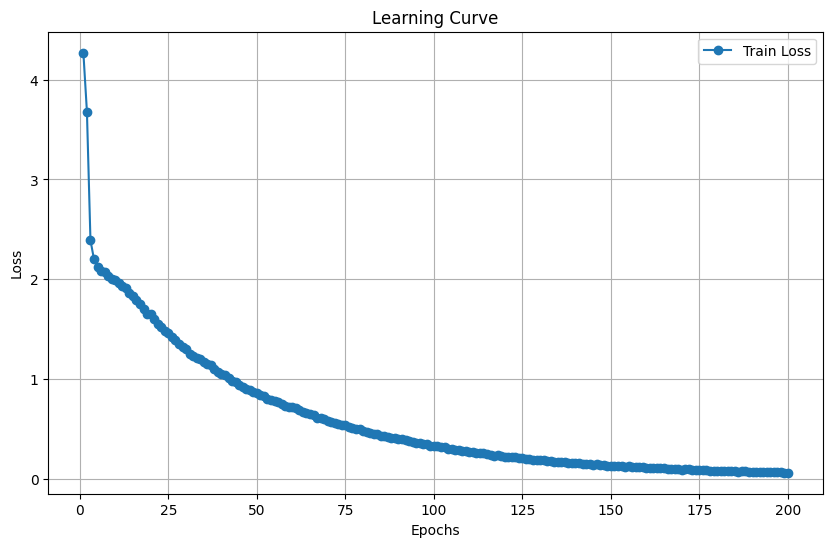

In [ ]:
# Plot training progress
plot_learning_curve(losses)

In [ ]:
# Save trained model
model_save_path = "bilstm_ner_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


### Inference Functions

In [ ]:
def predict_from_file(file_path, model, vocab, label_vocab, device):
    """
    Make predictions on a text file using trained model
    
    Args:
        file_path: Path to text file
        model: Trained model
        vocab: Token vocabulary
        label_vocab: Label vocabulary
        device: Computation device
        
    Returns:
        List of (token, predicted_label) tuples
    """
    # Read input file
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Tokenize text
    tokens = text.split()

    # Convert tokens to indices
    token_ids = [vocab.stoi.get(token, vocab.stoi["<unk>"]) for token in tokens]

    # Create input tensor
    input_tensor = torch.tensor([token_ids]).to(device)

    # Make predictions
    model.eval() 
    with torch.no_grad():
        outputs = model(input_tensor)
        predictions = torch.argmax(outputs, dim=-1).cpu().numpy().flatten()

    # Convert indices to labels
    predicted_labels = [label_vocab.itos[idx] for idx in predictions]

    return list(zip(tokens, predicted_labels))


In [ ]:
# Example usage
file_path = "/kaggle/input/test-file/test.txt"
loaded_model = BiLSTMNER(len(vocab), embed_dim, hidden_dim, num_classes)
loaded_model.load_state_dict(torch.load("bilstm_ner_model.pth"))
loaded_model.to(device)

predictions = predict_from_file(file_path, loaded_model, vocab, label_vocab, device)

# Print predictions
for token, label in predictions:
    print(f"{token}: {label}")


CASE:: O
A: O
34-year-old: B-Age
woman: B-Sex
with: O
no: B-History
significant: I-History
past: I-History
medical: I-History
history: I-History
presented: B-Clinical_event
with: O
a: O
4-month: B-Duration
history: O
of: O
intermittent: B-History
episodes: O
of: O
chest: B-Biological_structure
discomfort.: O
The: O
symptoms: B-Sign_symptom
occurred: O
predominantly: B-Lab_value
during: O
physical: B-Diagnostic_procedure
exertion,: O
lasted: O
between: O
10: B-Date
to: O
15: B-Date
minutes,: O
and: O
were: O
occasionally: O
accompanied: O
by: O
lightheadedness: O
and: O
sweating.: O
Physical: B-Diagnostic_procedure
examination: I-Diagnostic_procedure
revealed: O
a: O
mid-systolic: O
click: O
followed: O
by: O
a: O
late: B-Detailed_description
systolic: I-Sign_symptom
murmur,: O
best: O
heard: O
at: O
the: O
apex,: O
consistent: O
with: O
mitral: B-Diagnostic_procedure
valve: I-Diagnostic_procedure
prolapse.: O
No: O
other: B-Lab_value
abnormal: I-Lab_value
findings: I-Diagnostic_procedu

<ipython-input-22-b8f685ae17f6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("bilstm_ner_model.pth"))
